In [1]:
!apt-get -qq install fonts-nanum

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import matplotlib.font_manager as fm
import matplotlib.pylab as plb

# 샘플링 코드
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTEENN

import os

#사이킷 런 라이브러리
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression

import pickle
import numpy as np
import pandas as pd

mpl.style.use("seaborn-v0_8")
mpl.rcParams.update({"figure.constrained_layout.use": True})
sns.set_context("paper")
sns.set_palette("Set2")
sns.set_style("whitegrid")
plt.rcParams["axes.unicode_minus"] = False

#폰트 설치 및 지정
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# 그리드 서치와 랜더마이즈 서치함수

def grid_serch(train_x, train_y, model, params, how_):
    """
    최적의 파라미터를 찾는 기준이 accuracy 로 되어 있어 불균형한 데이터에는 맞지 않는다고 생각하여
    scoring 방법을 precision 또는 Recall 값으로 한다.
    """
    scorer = make_scorer(how_)
    grid_model = GridSearchCV(model,
                              params,
                              cv=StratifiedKFold(5,shuffle=True,random_state=42),
                              n_jobs=-1,
                              verbose=1,
                              scoring=scorer)
    grid_model.fit(train_x, train_y)
    return grid_model

def rand_search(train_x, train_y, model, params, n_iters, how_):
    # scoring 방법을 accuracy 가 아닌 precision 또는 Recall 값으로 한다
    scorer = make_scorer(how_)
    rand_model = RandomizedSearchCV(model,
                                    params,
                                    cv=StratifiedKFold(5,shuffle=True,random_state=42),
                                    n_jobs=-1,
                                    n_iter=n_iters,
                                    verbose=1,
                                    scoring=scorer)
    rand_model.fit(train_x, train_y)
    return rand_model

# 모델의, 테스트 데이터에 대하여 프리시전, 리콜, 정확도를 계산하고, 이를 보여주고, 또 리턴한다.
def prc_rec_prob(test_x ,test_y ,model_, name_):
    precision = precision_score(test_y, model_.predict(test_x), pos_label=1)
    recall = recall_score(test_y, model_.predict(test_x), pos_label=1)
    accuracy = accuracy_score(test_y, model_.predict(test_x))

    print(f'{name_: <20}',end=" |")
    print(f'Precision: {precision:.2f}',end=" |")
    print(f'Recall: {recall:.2f}',end=" |")
    print(f'Accuracy: {accuracy:.2f}')

    return precision, recall, accuracy

# 아래의 위의 함수보다 좀더 많은 결과값을 보여주기 위한 함수
def result(model, x_train, y_train, x_test, y_test):
    pred = model.predict(x_test)
    print("정확도",accuracy_score(pred, y_test))
    print("confusion_matri\n",confusion_matrix(y_test, pred))
    print("\nclassification_report")
    print(classification_report(y_test, pred))
    print("*"*50)

# 모델을 파일로 저장한다.
def save_model_func(model, name):
    with open(f'horse_models/{name}', 'wb') as f:
        pickle.dump(model, f)

# 저장한 모델을 불러온다.
def open_model_func(dir):
    with open(f'{dir}', 'rb') as f:
        open_model = pickle.load(f)
    return open_model

# 데이터 프레임에 저장하기 위한 합수
def add_to_df(df, model ,name, params, sampling, features):
    precision, recall, accuracy = prc_rec_prob(test_x, test_y, model, name)

    faces = roc_auc_score(test_y, model.predict_proba(test_x)[:,1])
    f1___ = 2 * (precision * recall) / (precision + recall)
    row = [f"{name}", params, sampling, features, precision, recall, accuracy, f1___ , faces]
    df.loc[len(df)] = row

    return df

# 모델을 스택하고, 그모델을 반환, 불러온 후에 추후 파일로 저장한다.
def stacking_model_result(to_stack, x_ros, y_ros):
    stack_model_ = StackingClassifier(estimators=to_stack, # [("knn" , knn, ), ("rf" , rf, )]
                                      final_estimator=LogisticRegression())
    stack_model_.fit(x_ros, y_ros)
    print("*" * 100)
    return stack_model_

# Precision-Recall 곡선을 그리기 위한 함수 정의
def plot_precision_recall_curve(y_true, y_probs, model_name):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    return recall, precision, model_name

In [5]:
horse_run = pd.read_csv("data\horse_run_final.csv", index_col=0)

In [6]:
horse_run

,착순,기수경력(년),마필연령,부담중량,조교사경력(년),출주번호,습도,외산,수,암,무게,무게 증감량,경주마통산1착비율,기수통산1착비율
0,1,9,3,55.0,27.0,9,0.18,False,False,False,311,-18,0.500000,0.135868
1,0,13,3,54.0,29.0,2,0.18,False,False,True,283,-6,0.000000,0.093869
2,0,18,4,55.0,27.0,3,0.18,False,True,False,271,-5,0.000000,0.156444
3,0,6,2,54.0,27.0,6,0.18,False,False,True,265,-8,0.000000,0.080102
4,0,27,3,53.0,32.0,1,0.18,False,False,True,265,-2,0.000000,0.105547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63288,0,11,4,51.0,19.0,10,0.03,False,False,False,504,6,0.125000,0.060915
63289,0,9,5,52.0,11.0,12,0.03,False,True,False,494,-9,0.150000,0.056047
63290,0,13,7,55.0,15.0,6,0.03,False,False,False,467,2,0.156250,0.063735
63291,0,33,7,55.0,15.0,6,0.03,False,False,False,467,2,0.156250,0.063735


### 라벨 불균형 해결하기

In [7]:
# horse_run["착순"].value_counts()

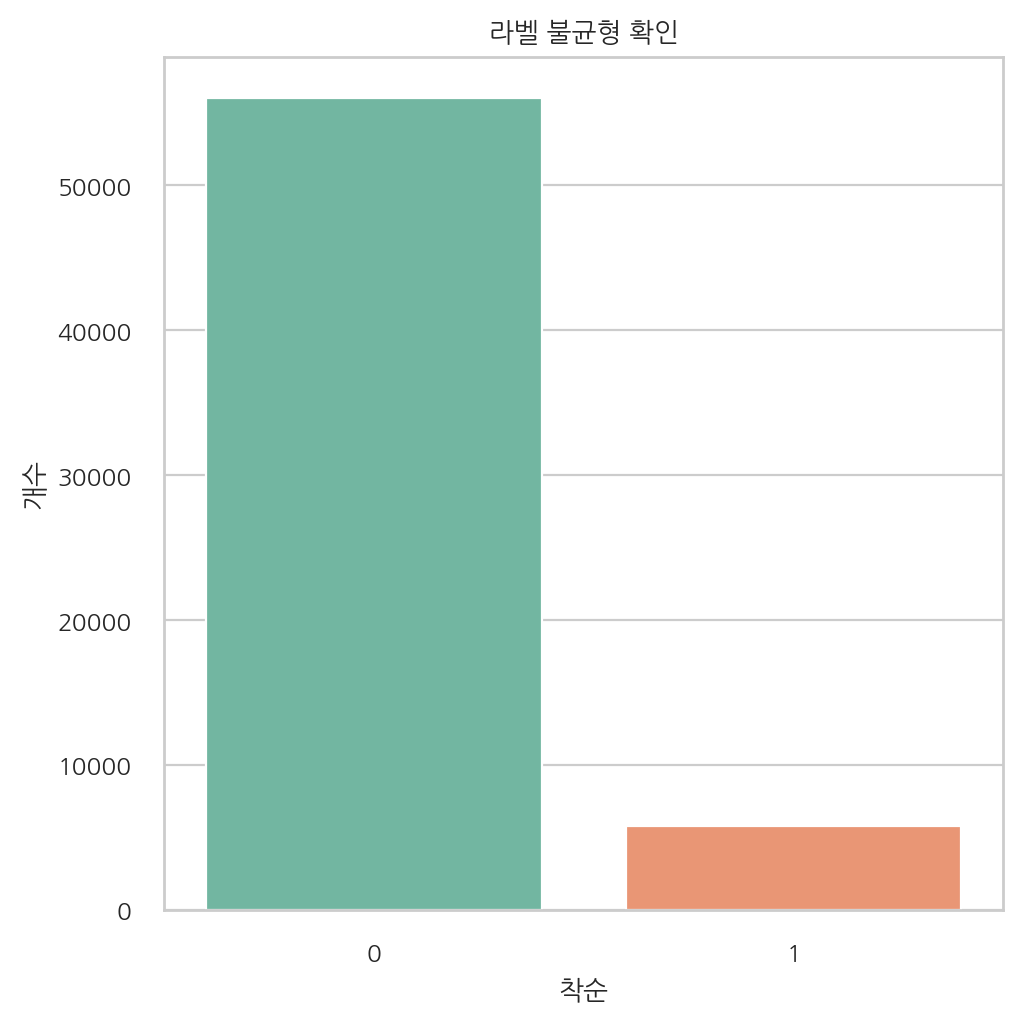

In [8]:
# 착순 라벨의 불균형 확인
label_counts = horse_run["착순"].value_counts()
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax)
ax.set_title("라벨 불균형 확인")
ax.set_xlabel("착순")
ax.set_ylabel("개수")
plt.show()

In [9]:
X = horse_run.drop("착순", axis=1)
y = horse_run["착순"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
result_csv = pd.DataFrame(columns=[
    '모델명',
    '하이퍼 파라미터',
    '샘플링 기법',
    '사용피쳐',
    'precision',
    'recall',
    'accuracy',
    'f1-score',
    'roc_auc 커브 면적'])

In [11]:
nosample_df = pd.DataFrame(columns=result_csv.columns)

In [12]:
# 노 샘플링 기본 모델
# knn_all_default = KNeighborsClassifier()
# dt_all_default = DecisionTreeClassifier()
# rf_all_default = RandomForestClassifier()
# ad_all_default = AdaBoostClassifier()
# xg_all_default = XGBClassifier()

# knn_all_default.fit(train_x, train_y)
# dt_all_default.fit(train_x, train_y)
# rf_all_default.fit(train_x, train_y)
# ad_all_default.fit(train_x, train_y)
# xg_all_default.fit(train_x, train_y)

# save_model_func(knn_all_default, "knn_all_default")
# save_model_func(dt_all_default, "dt_all_default")
# save_model_func(rf_all_default, "rf_all_default")
# save_model_func(ad_all_default, "ad_all_default")
# save_model_func(xg_all_default, "xg_all_default")

# 위에서 저장한 모델을 열어 각 각 변수에 할당
knn_all_default = open_model_func("horse_models/knn_all_default")
dt_all_default  = open_model_func("horse_models/dt_all_default")
rf_all_default  = open_model_func("horse_models/rf_all_default")
ad_all_default  = open_model_func("horse_models/ad_all_default")
xg_all_default  = open_model_func("horse_models/xg_all_default")

# 데이터 프레임에 추가하는 과정
add_to_df(nosample_df, knn_all_default, "knn_all_default", "default", "no_sampling", "all")
add_to_df(nosample_df, dt_all_default, "dt_all_default", "default", "no_sampling", "all")
add_to_df(nosample_df, rf_all_default, "rf_all_default", "default", "no_sampling", "all")
add_to_df(nosample_df, ad_all_default, "ad_all_default", "default", "no_sampling", "all")
add_to_df(nosample_df, xg_all_default, "xg_all_default", "default", "no_sampling", "all")


knn_all_default      |Precision: 0.13 |Recall: 0.02 |Accuracy: 0.90
dt_all_default       |Precision: 0.24 |Recall: 0.27 |Accuracy: 0.85
rf_all_default       |Precision: 0.57 |Recall: 0.09 |Accuracy: 0.91
ad_all_default       |Precision: 0.62 |Recall: 0.09 |Accuracy: 0.91
xg_all_default       |Precision: 0.54 |Recall: 0.12 |Accuracy: 0.91


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
0,knn_all_default,default,no_sampling,all,0.129630,0.018309,0.897575,0.032086,0.555446
1,dt_all_default,default,no_sampling,all,0.242590,0.271142,0.853921,0.256072,0.592312
2,rf_all_default,default,no_sampling,all,0.570652,0.091543,0.909378,0.157776,0.792821
3,ad_all_default,default,no_sampling,all,0.618750,0.086312,0.910348,0.151492,0.816180
4,xg_all_default,default,no_sampling,all,0.539370,0.119442,0.908892,0.195575,0.808947


In [13]:
nosample_df.to_csv("result_csv/1. no_sampled_model.csv")

### 각 샘플링별 시행

In [14]:
# 각 샘플링을 결과를 담을 dict 만들기
x_y_name = {}

# 랜덤 언더 샘플링
rus = RandomUnderSampler(random_state=0)
x_rus, y_rus = rus.fit_resample(train_x,train_y)

# ENN
enn = EditedNearestNeighbours(kind_sel="all", n_neighbors=5)
x_enn, y_enn = enn.fit_resample(train_x,train_y)

# RandomOver
ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(train_x,train_y)

# SMOTE
smo = SMOTE(random_state=0)
x_smo, y_smo = smo.fit_resample(train_x,train_y)

smoenn = SMOTEENN(random_state=0)
x_smoenn, y_smoenn = smoenn.fit_resample(train_x,train_y)

x_y_name["rus"] = x_rus, y_rus
x_y_name["enn"] = x_enn, y_enn
x_y_name["ros"] = x_ros, y_ros
x_y_name["smo"] = x_smo, y_smo
x_y_name["smoenn"] = x_smoenn, y_smoenn

In [15]:
# 샘플링 후의 각 라벨 데이터의 비율
for x_y, name in zip(x_y_name.values(), x_y_name.keys()):
    print(f"{name} : {x_y[1].value_counts()[1] / (x_y[1].value_counts()[0] + x_y[1].value_counts()[1])}")

rus : 0.5
enn : 0.1418467702768334
ros : 0.5
smo : 0.5
smoenn : 0.6145125368201738


### 샘플링 선택을 위해 기본 모델로 fit

In [16]:
sampled_default_model_df = pd.DataFrame(columns=result_csv.columns)

In [17]:
for key in x_y_name.keys():
    print(key,"샘플링의 각 결과")
    knn = KNeighborsClassifier()
    dt = DecisionTreeClassifier()
    rf = RandomForestClassifier()
    ad = AdaBoostClassifier()
    xg = XGBClassifier()

    x__ , y__ = x_y_name[key][0], x_y_name[key][1]
    knn.fit(x__,y__)
    dt.fit(x__, y__)
    rf.fit(x__, y__)
    ad.fit(x__, y__)
    xg.fit(x__, y__)

    models = [knn, dt, rf, ad, xg]
    model_names = ['knn', 'decision Tree', 'random forest', 'ada boost', 'xg boost']

    # 함수를 사용하는 것으로 바꿔야함
    for model, model_name in zip(models, model_names):
        with open(f'horse_models/{key}_{model_name}', 'wb') as f:
            pickle.dump(model, f)
        
    # 이것도 마찬가지
    for model, name in zip(models, model_names):
        precision, recall, accuracy = prc_rec_prob(test_x, test_y, model, name)

        faces = roc_auc_score(test_y, model.predict_proba(test_x)[:,1])
        f1___ = 2 * (precision * recall) / (precision + recall)
        row = [f"{key}_{name}", 'default', f"{key}", 'All', precision, recall, accuracy, f1___ , faces]


        sampled_default_model_df.loc[len(sampled_default_model_df)] = row

    print("-" * 50)
    print("*" * 50)
    print("")

rus 샘플링의 각 결과
knn                  |Precision: 0.11 |Recall: 0.59 |Accuracy: 0.53
decision Tree        |Precision: 0.16 |Recall: 0.65 |Accuracy: 0.65
random forest        |Precision: 0.20 |Recall: 0.74 |Accuracy: 0.70
ada boost            |Precision: 0.20 |Recall: 0.76 |Accuracy: 0.70
xg boost             |Precision: 0.20 |Recall: 0.75 |Accuracy: 0.69
--------------------------------------------------
**************************************************

enn 샘플링의 각 결과
knn                  |Precision: 0.16 |Recall: 0.17 |Accuracy: 0.84
decision Tree        |Precision: 0.21 |Recall: 0.38 |Accuracy: 0.81
random forest        |Precision: 0.41 |Recall: 0.25 |Accuracy: 0.90
ada boost            |Precision: 0.42 |Recall: 0.25 |Accuracy: 0.90
xg boost             |Precision: 0.37 |Recall: 0.29 |Accuracy: 0.89
--------------------------------------------------
**************************************************

ros 샘플링의 각 결과
knn                  |Precision: 0.12 |Recall: 0.32 |Accuracy: 0.72
deci

In [18]:
sampled_default_model_df.to_csv("result_csv/2. simple_sampling_test.csv")

### 샘플링 결정
- 각 샘플링 별 개별 모델의
    - precision, recall, accuracy를 보았을때 random over sampling이 적정하다고 판단되었다
    - random over sampling
        - random over sampling 의 랜덤 포레스트의 프리시전(0.48)이 높은 편이고
        - ada boost의 리콜(0.77)이 높은 편이다.
        - 정확도는 테스트 데이터에 대하여 전체 라벨의 불균형으로 인해 큰 의미는 없어보인다.

In [19]:
dt_param = {
    "criterion": ["gini", "entropy"],  # 불순도 측정 방법
    "splitter": ["best", "random"],  # 최적의 분할을 찾기 위한 전략
    "max_depth": [None, 10, 20, 30, 40, 50],  # 트리의 최대 깊이
    "min_samples_split": [2, 5, 10, 20],  # 노드를 분할하기 위한 최소 샘플 수
    "min_samples_leaf": [1, 5, 10, 20],  # 리프 노드가 되기 위한 최소 샘플 수
    "max_features": ["sqrt", "log2"],  # 최적의 분할을 찾기 위한 전략
    "max_leaf_nodes": [None, 10, 20, 30, 50],  # 리프 노드의 최대 개수
    "min_impurity_decrease": [0.0, 0.05, 0.1]  # 노드를 분할하기 위한 최소 불순도
}

knn_param = {
    "n_neighbors": range(1,2000),  # 최근접 이웃의 개수
    "p": [1, 2]  # 거리 측정 방법 (1: 맨하튼, 2: 유클리디언 거리)
}

rf_param = {
    "n_estimators": range(10,2000,10),  # 트리의 개수
    "max_depth": [None, 10, 20, 30, 50],  # 트리의 최대 깊이
    "oob_score": [True],  # OOB 스코어 반환 여부
    "max_features": ["sqrt", "log2"],  # 각 트리의 최대 특징 수
    "min_samples_leaf": [1, 5, 10, 20],  # 리프 노드가 되기 위한 최소 샘플 수
    "min_samples_split": [2, 5, 10, 20],  # 노드를 분할하기 위한 최소 샘플 수
    "max_leaf_nodes": [None, 10, 20, 30, 50]  # 리프 노드의 최대 개수
}

ada_param = {
    "n_estimators": range(10,2000,10),  # 부스팅 단계의 수
    "learning_rate": [0.01, 0.05, 0.1, 0.5],  # 학습률
}

xgb_param = {
    "n_estimators": range(10,2000,10),  # 부스팅 단계의 수
    "learning_rate": [0.01, 0.05, 0.1, 0.3],  # 학습률
    "max_depth": [3, 6, 10, 15],  # 트리의 최대 깊이
}

In [20]:
# # best recall
# knn_rs_best_recall = rand_search(x_ros, y_ros, KNeighborsClassifier(), knn_param, 100, recall_score)
# dt_gs_best_recall = rand_search(x_ros, y_ros, DecisionTreeClassifier(), dt_param, 100, recall_score)
# rf_rs_best_recall = rand_search(x_ros, y_ros, RandomForestClassifier(), rf_param, 100, recall_score)
# ad_rs_best_recall = rand_search(x_ros, y_ros, AdaBoostClassifier(), ada_param, 100, recall_score)
# xg_rs_best_recall = rand_search(x_ros, y_ros, XGBClassifier(), xgb_param, 100, recall_score)

# save_model_func(knn_rs_best_recall.best_estimator_, "best_of_ros_knn_rs_recall")
# save_model_func(dt_gs_best_recall.best_estimator_, "best_of_ros_dt_rs_recall")
# save_model_func(rf_rs_best_recall.best_estimator_, "best_of_ros_rf_rs_precision")
# save_model_func(ad_rs_best_recall.best_estimator_, "best_of_ros_ad_rs_recall")
# save_model_func(xg_rs_best_recall.best_estimator_, "best_of_ros_xg_rs_recall")

# print(knn_rs_best_recall.best_params_)
# print(dt_gs_best_recall.best_params_)
# print(rf_rs_best_recall.best_params_)
# print(ad_rs_best_recall.best_params_)
# print(xg_rs_best_recall.best_params_)

In [21]:
# # best precision
# knn_rs_best_precision = rand_search(x_ros, y_ros, KNeighborsClassifier(), knn_param, 100, precision_score)
# dt_gs_best_precision = rand_search(x_ros, y_ros, DecisionTreeClassifier(), dt_param, 100, precision_score)
# rf_rs_best_precision = rand_search(x_ros, y_ros, RandomForestClassifier(), rf_param, 100, precision_score)
# ad_rs_best_precision = rand_search(x_ros, y_ros, AdaBoostClassifier(), ada_param, 100, precision_score)
# xg_rs_best_precision = rand_search(x_ros, y_ros, XGBClassifier(), xgb_param, 100, precision_score)

# save_model_func(knn_rs_best_precision.best_estimator_, "best_of_ros_knn_rs_precision")
# save_model_func(dt_gs_best_precision.best_estimator_, "best_of_ros_dt_rs_precision")
# save_model_func(rf_rs_best_precision.best_estimator_, "best_of_ros_rf_rs_precision")
# save_model_func(ad_rs_best_precision.best_estimator_, "best_of_ros_ad_rs_precision")
# save_model_func(xg_rs_best_precision.best_estimator_, "best_of_ros_xg_rs_precision")

# print(knn_rs_best_precision.best_params_)
# print(dt_gs_best_precision.best_params_)
# print(rf_rs_best_precision.best_params_)
# print(ad_rs_best_precision.best_params_)
# print(xg_rs_best_precision.best_params_)

In [22]:
best_param_df = pd.DataFrame(columns=result_csv.columns)

In [23]:
knn_rs_best_precision = open_model_func("horse_models/best_of_ros_knn_rs_precision")
dt_gs_best_precision = open_model_func("horse_models/best_of_ros_dt_rs_precision")
rf_rs_best_precision = open_model_func("horse_models/best_of_ros_rf_rs_precision")
ad_rs_best_precision = open_model_func("horse_models/best_of_ros_ad_rs_precision")
xg_rs_best_precision = open_model_func("horse_models/best_of_ros_xg_rs_precision")
knn_rs_best_recall = open_model_func("horse_models/best_of_ros_knn_rs_recall")
dt_gs_best_recall = open_model_func("horse_models/best_of_ros_dt_rs_recall")
rf_rs_best_recall = open_model_func("horse_models/best_of_ros_rf_rs_recall")
ad_rs_best_recall = open_model_func("horse_models/best_of_ros_ad_rs_recall")
xg_rs_best_recall = open_model_func("horse_models/best_of_ros_xg_rs_recall")

best_precisions = {}
best_recalls = {}

best_precisions["best_of_ros_knn_rs_precision"] = knn_rs_best_precision
best_precisions["best_of_ros_dt_rs_precision"] = dt_gs_best_precision
best_precisions["best_of_ros_rf_rs_precision"] = rf_rs_best_precision
best_precisions["best_of_ros_ad_rs_precision"] = ad_rs_best_precision
best_precisions["best_of_ros_xg_rs_precision"] = xg_rs_best_precision
best_recalls["best_of_ros_knn_rs_recall"] = knn_rs_best_recall
best_recalls["best_of_ros_dt_rs_recall"] = dt_gs_best_recall
best_recalls["best_of_ros_rf_rs_recall"] = rf_rs_best_recall
best_recalls["best_of_ros_ad_rs_recall"] = ad_rs_best_recall
best_recalls["best_of_ros_xg_rs_recall"] = xg_rs_best_recall

In [24]:
for prec, reca in zip(best_precisions, best_recalls):
    add_to_df(best_param_df ,best_precisions[prec], prec, best_precisions[prec].get_params(), "ros" , "all")
    add_to_df(best_param_df ,best_recalls[reca], reca, best_recalls[reca].get_params(), "ros" , "all")

best_of_ros_knn_rs_precision |Precision: 0.12 |Recall: 0.54 |Accuracy: 0.60
best_of_ros_knn_rs_recall |Precision: 0.13 |Recall: 0.43 |Accuracy: 0.68
best_of_ros_dt_rs_precision |Precision: 0.19 |Recall: 0.52 |Accuracy: 0.75
best_of_ros_dt_rs_recall |Precision: 0.22 |Recall: 0.22 |Accuracy: 0.85
best_of_ros_rf_rs_precision |Precision: 0.48 |Recall: 0.17 |Accuracy: 0.91
best_of_ros_rf_rs_recall |Precision: 0.35 |Recall: 0.36 |Accuracy: 0.88
best_of_ros_ad_rs_precision |Precision: 0.21 |Recall: 0.76 |Accuracy: 0.71
best_of_ros_ad_rs_recall |Precision: 0.21 |Recall: 0.76 |Accuracy: 0.71
best_of_ros_xg_rs_precision |Precision: 0.36 |Recall: 0.20 |Accuracy: 0.89
best_of_ros_xg_rs_recall |Precision: 0.39 |Recall: 0.21 |Accuracy: 0.90


In [25]:
best_param_df.to_csv("result_csv/3. best_param_df.csv")

### 스테킹 모델을 통한 모델 개선

- Random Forest 의 높은 프리시전, AdaBoost의 높은 리콜값을 조합하면 데이터 불균형에 대해 개선될 것이라고 예상

In [26]:
stacked_df = pd.DataFrame(columns=result_csv.columns)
best_precisions.keys(), best_recalls.keys() # 를 이용하여 각 precision 과 recall 기준의 최고의 파라미터로 만든 모델을 조합할 예정

(dict_keys(['best_of_ros_knn_rs_precision', 'best_of_ros_dt_rs_precision', 'best_of_ros_rf_rs_precision', 'best_of_ros_ad_rs_precision', 'best_of_ros_xg_rs_precision']),
 dict_keys(['best_of_ros_knn_rs_recall', 'best_of_ros_dt_rs_recall', 'best_of_ros_rf_rs_recall', 'best_of_ros_ad_rs_recall', 'best_of_ros_xg_rs_recall']))

In [27]:
# # 모든 스택 경우의 수 모델 저장
# for prec in best_precisions:
#     for reca in best_recalls:
#         stacks = [(prec, best_precisions[prec]), (reca ,best_recalls[reca])]
#         stacked_model = stacking_model_result(stacks, x_ros, y_ros)

#         save_model_func(stacked_model , f"stacked_{prec},{reca}")

In [28]:
# 저장된 스택 모델 불러오기 (미리, 스텍 모델들을 불러와야지만 불러와짐 : 이름때문)
all_stacked_models = {}

for prec in best_precisions:
    for reca in best_recalls:
        stacked_model = open_model_func(f"horse_models/stacked_{prec},{reca}")
        all_stacked_models[f"stacked_{prec},{reca}"] = stacked_model

In [29]:
stacks_param_df = pd.DataFrame(columns=result_csv.columns)

In [30]:
# 데이터 스택 모델 데이터 프레임 만들기
for model in all_stacked_models:
    add_to_df(stacks_param_df, all_stacked_models[model] ,model,all_stacked_models[model].get_params(), "ros", "all")

stacked_best_of_ros_knn_rs_precision,best_of_ros_knn_rs_recall |Precision: 0.13 |Recall: 0.33 |Accuracy: 0.74
stacked_best_of_ros_knn_rs_precision,best_of_ros_dt_rs_recall |Precision: 0.26 |Recall: 0.22 |Accuracy: 0.87
stacked_best_of_ros_knn_rs_precision,best_of_ros_rf_rs_recall |Precision: 0.46 |Recall: 0.18 |Accuracy: 0.90
stacked_best_of_ros_knn_rs_precision,best_of_ros_ad_rs_recall |Precision: 0.14 |Recall: 0.45 |Accuracy: 0.68
stacked_best_of_ros_knn_rs_precision,best_of_ros_xg_rs_recall |Precision: 0.52 |Recall: 0.08 |Accuracy: 0.91
stacked_best_of_ros_dt_rs_precision,best_of_ros_knn_rs_recall |Precision: 0.24 |Recall: 0.36 |Accuracy: 0.83
stacked_best_of_ros_dt_rs_precision,best_of_ros_dt_rs_recall |Precision: 0.23 |Recall: 0.22 |Accuracy: 0.86
stacked_best_of_ros_dt_rs_precision,best_of_ros_rf_rs_recall |Precision: 0.45 |Recall: 0.15 |Accuracy: 0.90
stacked_best_of_ros_dt_rs_precision,best_of_ros_ad_rs_recall |Precision: 0.20 |Recall: 0.52 |Accuracy: 0.76
stacked_best_of_ros_d

In [31]:
# 스택 모델 저장
stacks_param_df.to_csv("result_csv/4. stacks_param_df.csv")

In [32]:
# 모든 결과 불러오기
all_result_df = pd.concat([pd.read_csv("result_csv/1. no_sampled_model.csv"),
                           pd.read_csv("result_csv/2. simple_sampling_test.csv"),
                           pd.read_csv("result_csv/3. best_param_df.csv"),
                           pd.read_csv("result_csv/4. stacks_param_df.csv")],
                            ignore_index=True)
all_result_df.drop(columns=["Unnamed: 0"], inplace=True)

In [33]:
all_result_df.sort_values(by="f1-score",ascending=False).head(10)

,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
35,best_of_ros_rf_rs_recall,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",ros,all,0.349539,0.363557,0.878254,0.356410,0.812631
29,smoenn_xg boost,default,smoenn,All,0.324006,0.383609,0.868634,0.351297,0.807301
19,ros_xg boost,default,ros,All,0.233344,0.656495,0.768149,0.344307,0.805560
27,smoenn_random forest,default,smoenn,All,0.256297,0.505667,0.818108,0.340176,0.799607
23,smo_ada boost,default,smo,All,0.238129,0.585876,0.787793,0.338624,0.797158
22,smo_random forest,default,smo,All,0.344958,0.319093,0.880679,0.331522,0.801161
36,best_of_ros_ad_rs_precision,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",ros,all,0.210261,0.764603,0.711884,0.329823,0.819236
37,best_of_ros_ad_rs_recall,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",ros,all,0.210161,0.764603,0.711722,0.329699,0.819098
18,ros_ada boost,default,ros,All,0.208030,0.772450,0.706225,0.327784,0.817829
14,enn_xg boost,default,enn,All,0.367550,0.290323,0.887874,0.324403,0.808680


In [34]:
print("모든 예측모델의 대한 최댓 값")
print(all_result_df.max()[["precision", "recall", "accuracy", "f1-score", "roc_auc 커브 면적"]])
print("*"*20)

print("각 지표별 최고 모델")
print("precision")
pr_df = all_result_df[all_result_df["precision"] == all_result_df["precision"].max()]
display(pr_df)
print("recall")
rc_df = all_result_df[all_result_df["recall"] == all_result_df["recall"].max()]
display(rc_df)
print("accuracy")
ac_df = all_result_df[all_result_df["accuracy"] == all_result_df["accuracy"].max()]
display(ac_df)
print("f1-score")
f1_df = all_result_df[all_result_df["f1-score"] == all_result_df["f1-score"].max()]
display(f1_df)
print("roc_auc 커브 면적")
fc_df = all_result_df[all_result_df["roc_auc 커브 면적"] == all_result_df["roc_auc 커브 면적"].max()]
display(fc_df)

best_5_model = pd.concat([pr_df,rc_df,ac_df,f1_df,fc_df])

# worst 각 worst 모델도 비교해보기
print("모든 예측모델의 대한 최악 값")
print(all_result_df.min()[["precision", "recall", "accuracy", "f1-score", "roc_auc 커브 면적"]])
print("*"*20)

print("각 지표별 최악 모델")
print("precision")
pr_df_worst= all_result_df[all_result_df["precision"] == all_result_df["precision"].min()]
display(pr_df_worst)
print("recall")
rc_df_worst = all_result_df[all_result_df["recall"] == all_result_df["recall"].min()]
display(rc_df_worst)
print("accuracy")
ac_df_worst = all_result_df[all_result_df["accuracy"] == all_result_df["accuracy"].min()]
display(ac_df_worst)
print("f1-score")
f1_df_worst = all_result_df[all_result_df["f1-score"] == all_result_df["f1-score"].min()]
display(f1_df_worst)
print("roc_auc 커브 면적")
fc_df_worst = all_result_df[all_result_df["roc_auc 커브 면적"] == all_result_df["roc_auc 커브 면적"].min()]
display(fc_df_worst)

worst_5_model = pd.concat([pr_df_worst,rc_df_worst,ac_df_worst,f1_df_worst,fc_df_worst])

모든 예측모델의 대한 최댓 값
precision         0.72973
recall           0.998256
accuracy         0.910348
f1-score          0.35641
roc_auc 커브 면적    0.819236
dtype: object
********************
각 지표별 최고 모델
precision


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
51,"stacked_best_of_ros_rf_rs_precision,best_of_ro...","{'cv': None, 'estimators': [('best_of_precisio...",ros,all,0.72973,0.02354,0.90865,0.045608,0.804677


recall


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
58,"stacked_best_of_ros_ad_rs_precision,best_of_ro...","{'cv': None, 'estimators': [('best_of_recall_r...",ros,all,0.120034,0.998256,0.321261,0.214299,0.819182


accuracy


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
3,ad_all_default,default,no_sampling,all,0.61875,0.086312,0.910348,0.151492,0.81618


f1-score


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
35,best_of_ros_rf_rs_recall,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",ros,all,0.349539,0.363557,0.878254,0.35641,0.812631


roc_auc 커브 면적


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
36,best_of_ros_ad_rs_precision,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",ros,all,0.210261,0.764603,0.711884,0.329823,0.819236


모든 예측모델의 대한 최악 값
precision        0.112836
recall           0.018309
accuracy         0.321261
f1-score         0.032086
roc_auc 커브 면적    0.555446
dtype: object
********************
각 지표별 최악 모델
precision


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
5,rus_knn,default,rus,All,0.112836,0.589364,0.532255,0.189409,0.572826


recall


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
0,knn_all_default,default,no_sampling,all,0.12963,0.018309,0.897575,0.032086,0.555446


accuracy


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
58,"stacked_best_of_ros_ad_rs_precision,best_of_ro...","{'cv': None, 'estimators': [('best_of_recall_r...",ros,all,0.120034,0.998256,0.321261,0.214299,0.819182


f1-score


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
0,knn_all_default,default,no_sampling,all,0.12963,0.018309,0.897575,0.032086,0.555446


roc_auc 커브 면적


,모델명,하이퍼 파라미터,샘플링 기법,사용피쳐,precision,recall,accuracy,f1-score,roc_auc 커브 면적
0,knn_all_default,default,no_sampling,all,0.12963,0.018309,0.897575,0.032086,0.555446


In [35]:
best_worst_default = {}

In [36]:
# 베스트 모델 불러와서 각 이름별 딕셔너리에 넣기
for model in best_5_model["모델명"]:
    best_worst_default[model] = open_model_func(f"horse_models/{model}")

In [37]:
# worst 모델 불러와서 각 이름별 딕셔너리에 넣기
for model in worst_5_model["모델명"]:
    best_worst_default[model] = open_model_func(f"horse_models/{model}")

In [38]:
# 샘플링을 하지 않은 기본 모델
for model in ["knn_all_default", "dt_all_default", "rf_all_default", "ad_all_default", "xg_all_default"]:
    best_worst_default[model] = open_model_func(f"horse_models/{model}")

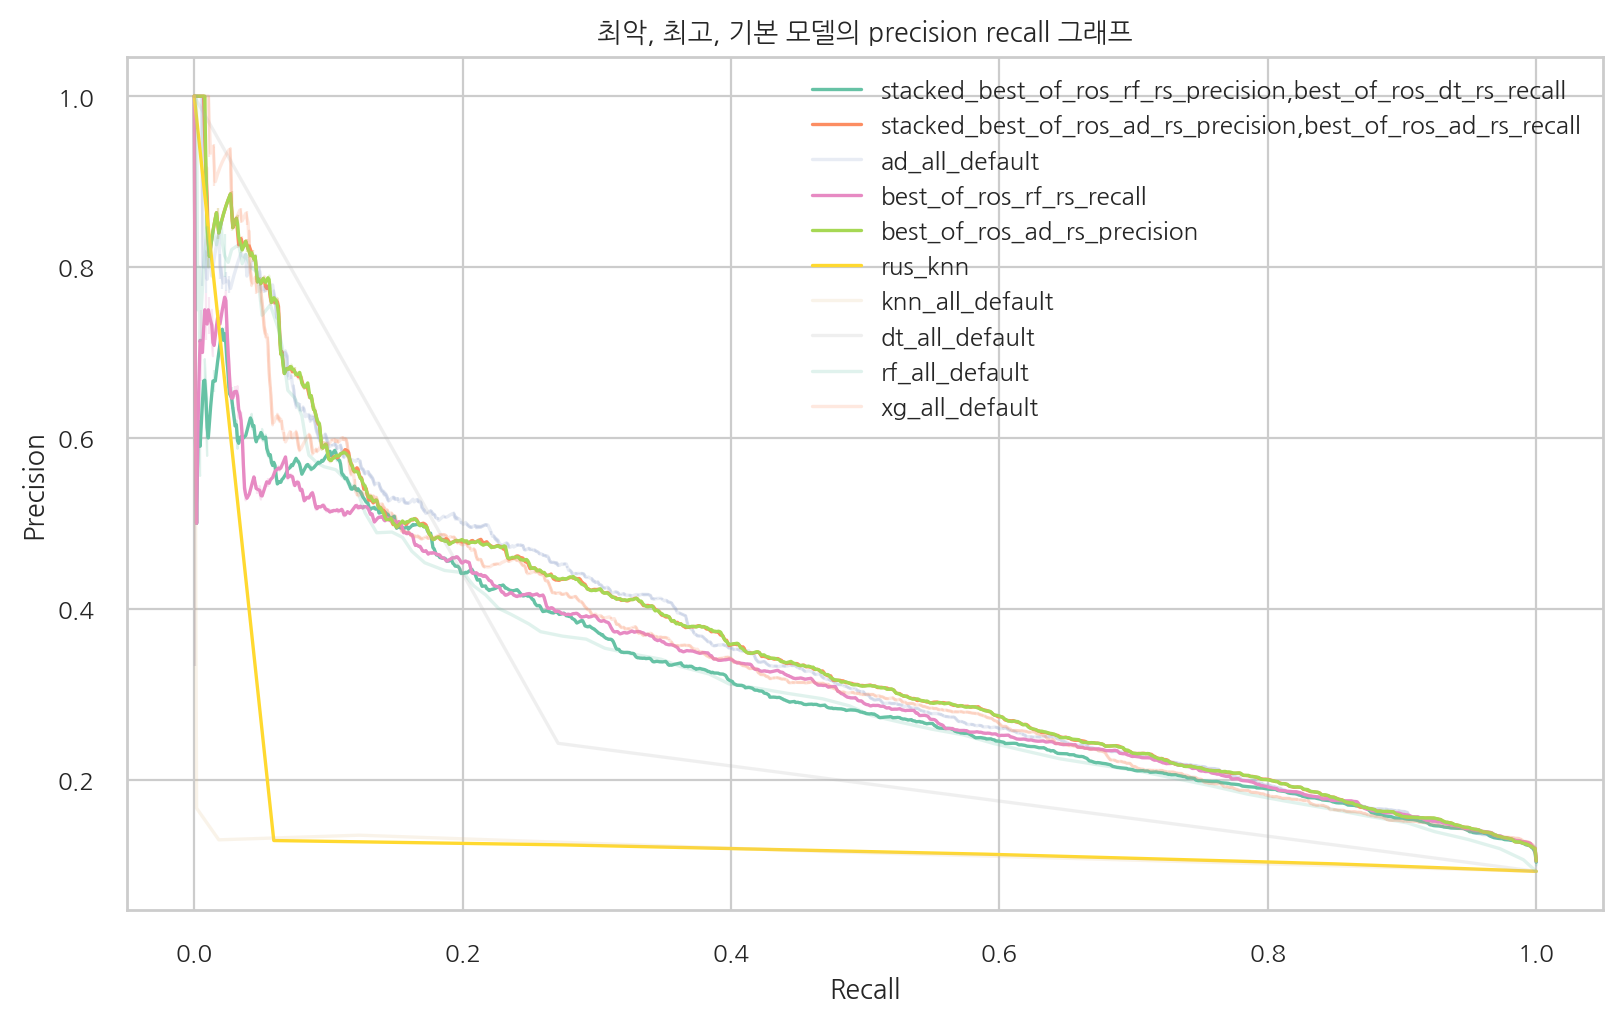

In [39]:
# precision recall graph 그리기
fig, ax = plt.subplots(figsize=(8, 5))

for key in best_worst_default:
    curve = plot_precision_recall_curve(test_y, best_worst_default[key].predict_proba(test_x)[:,1], key)
    sns.lineplot(
        x=curve[0],
        y=curve[1],
        label=curve[2],
        alpha=(0.2 if "default" in key else 1),
        ax=ax)

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('최악, 최고, 기본 모델의 precision recall 그래프')
ax.legend()

In [40]:
best_worst_default_roc = {}


for model in best_worst_default:
    fpr, tpr, _ = roc_curve(test_y, best_worst_default[model].predict_proba(test_x)[:,1])
    best_worst_default_roc[model] = (fpr, tpr)

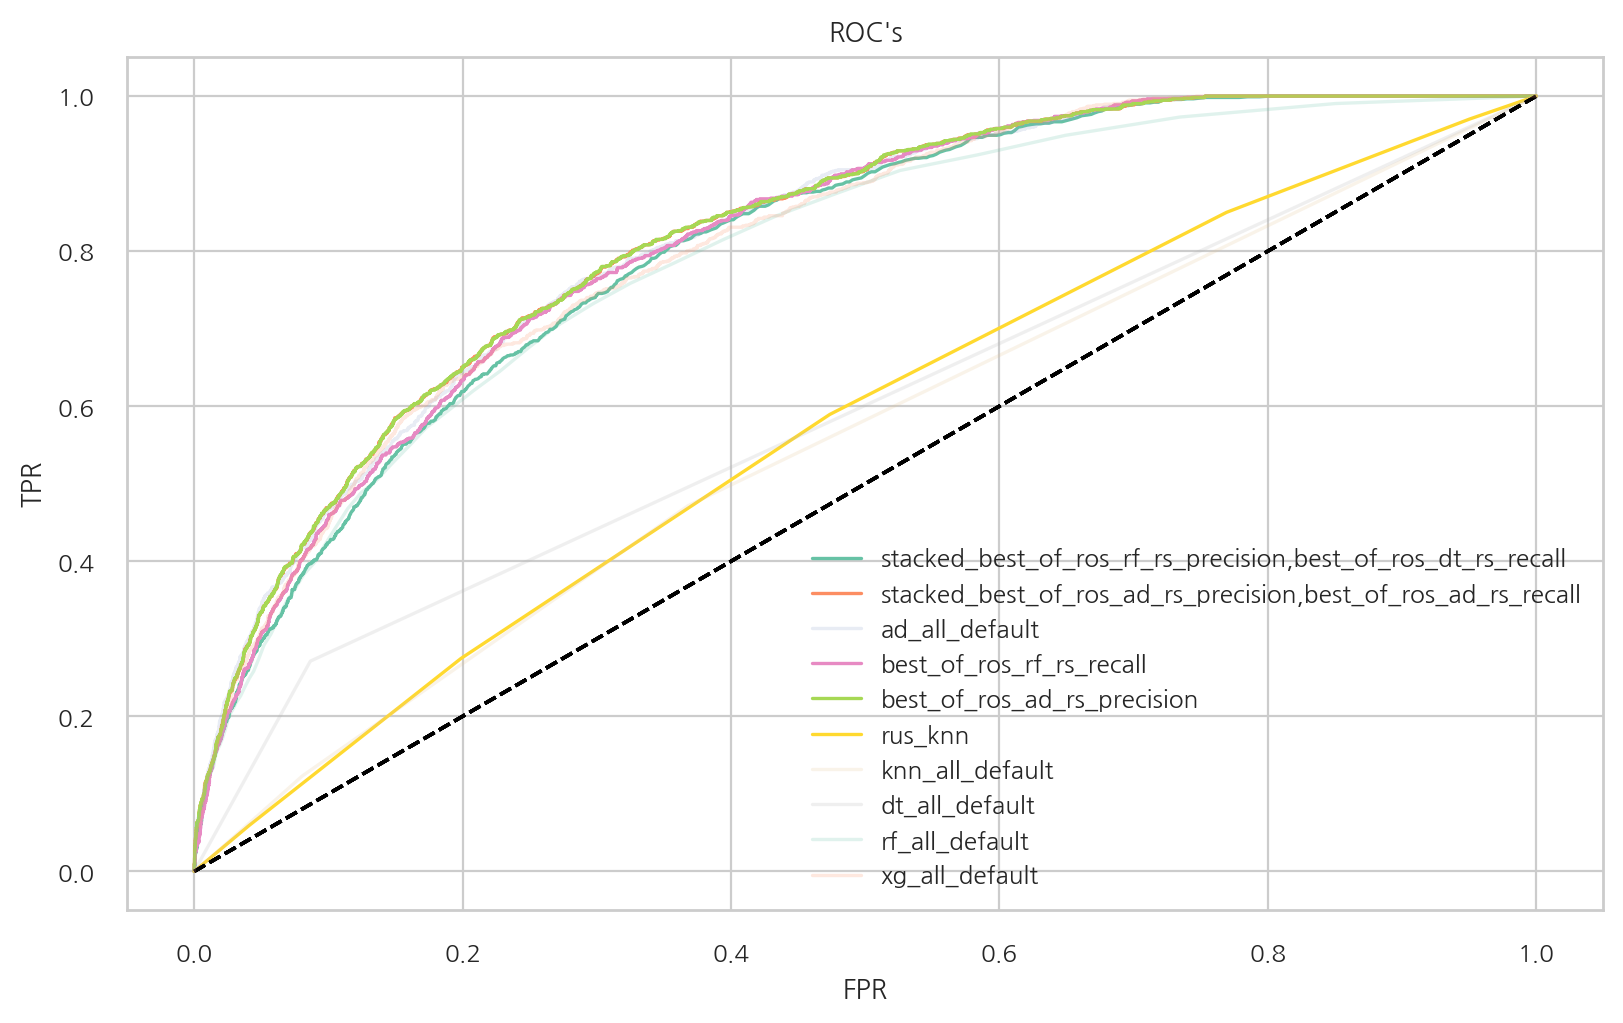

In [41]:
fig, ax = plt.subplots(figsize=(8,5))

for model in best_worst_default_roc:
    ax.plot([0,1],[0,1],"k--")
    ax.plot(best_worst_default_roc[model][0], best_worst_default_roc[model][1],alpha=(0.2 if "default" in model else 1), label=model)
    ax.set(xlabel="FPR", ylabel="TPR", title="ROC's")
    ax.legend();

### 모델 선정 예시

#### pricision 이 높은 모델의 해석
- 실제 데이터로 예측시, 전체 모델에 대하여 굉장히 보수적으로 정답 라벨이라고 분류를 한다.
- 실제 정답라벨로 분류한 데이터의 정답을 맞출 확률읜 73 퍼센트로 높은 비율이라고 볼 수 있다.
- 그러나, 경마장에 갔을 때, 배팅을 하지않고 집에 돌아올 확률은 크지만. 한번 예측을 해보면 그 정밀도는 0.73으로 높다고 볼 수 있다.

In [43]:
# 예시) 보수적인 사람을 위한 모델
print("전체 테스트 데이터중 실제로 1이라고 분류한 갯수")
print(best_worst_default["stacked_best_of_ros_rf_rs_precision,best_of_ros_dt_rs_recall"].predict(test_x).sum())
print("전체 테스트 데이터의 갯수")
print(len(test_x))
result(best_worst_default["stacked_best_of_ros_rf_rs_precision,best_of_ros_dt_rs_recall"], x_ros, y_ros, test_x, test_y)

전체 테스트 데이터중 실제로 1이라고 분류한 갯수
37
전체 테스트 데이터의 갯수
12370
정확도 0.9086499595796281
confusion_matri
 [[11213    10]
 [ 1120    27]]

classification_report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     11223
           1       0.73      0.02      0.05      1147

    accuracy                           0.91     12370
   macro avg       0.82      0.51      0.50     12370
weighted avg       0.89      0.91      0.87     12370

**************************************************


#### recall 이 높은 모델의 해석
- 실제 데이터로 예측 시 너무 많은 1등이 아닌 말들 까지도 1등으로 예측을 해버려서, 정확도 뿐 아니라, 실제로 오 분류할 가능성이 크다.

In [44]:
# 예시) 리콜값이 높은 모델
print("전체 테스트 데이터중 실제로 1이라고 분류한 갯수")
print(best_worst_default["stacked_best_of_ros_ad_rs_precision,best_of_ros_ad_rs_recall"].predict(test_x).sum())
print("전체 테스트 데이터의 갯수")
print(len(test_x))
result(best_worst_default["stacked_best_of_ros_ad_rs_precision,best_of_ros_ad_rs_recall"], x_ros, y_ros, test_x, test_y)

전체 테스트 데이터중 실제로 1이라고 분류한 갯수
9539
전체 테스트 데이터의 갯수
12370
정확도 0.32126111560226356
confusion_matri
 [[2829 8394]
 [   2 1145]]

classification_report
              precision    recall  f1-score   support

           0       1.00      0.25      0.40     11223
           1       0.12      1.00      0.21      1147

    accuracy                           0.32     12370
   macro avg       0.56      0.63      0.31     12370
weighted avg       0.92      0.32      0.39     12370

**************************************************


#### f1 score 가 가장 높은 모델의 해석
- 실제 1등의 라벨 비율이랑 비슷한 비율로 1등 라벨로 분류를 하지만
- 그중 35 퍼센트만 맞춘다.
- precision 과 recall의 조화, 하지만 프리시전이 낮은 편인것으로 보인다.

In [45]:
# 예시) f1 score 가 가장 높은 모델
print("전체 테스트 데이터중 실제로 1이라고 분류한 갯수")
print(best_worst_default["best_of_ros_rf_rs_recall"].predict(test_x).sum())
print("전체 테스트 데이터의 갯수")
print(len(test_x))
result(best_worst_default["best_of_ros_rf_rs_recall"], x_ros, y_ros, test_x, test_y)

전체 테스트 데이터중 실제로 1이라고 분류한 갯수
1193
전체 테스트 데이터의 갯수
12370
정확도 0.8782538399353274
confusion_matri
 [[10447   776]
 [  730   417]]

classification_report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     11223
           1       0.35      0.36      0.36      1147

    accuracy                           0.88     12370
   macro avg       0.64      0.65      0.64     12370
weighted avg       0.88      0.88      0.88     12370

**************************************************


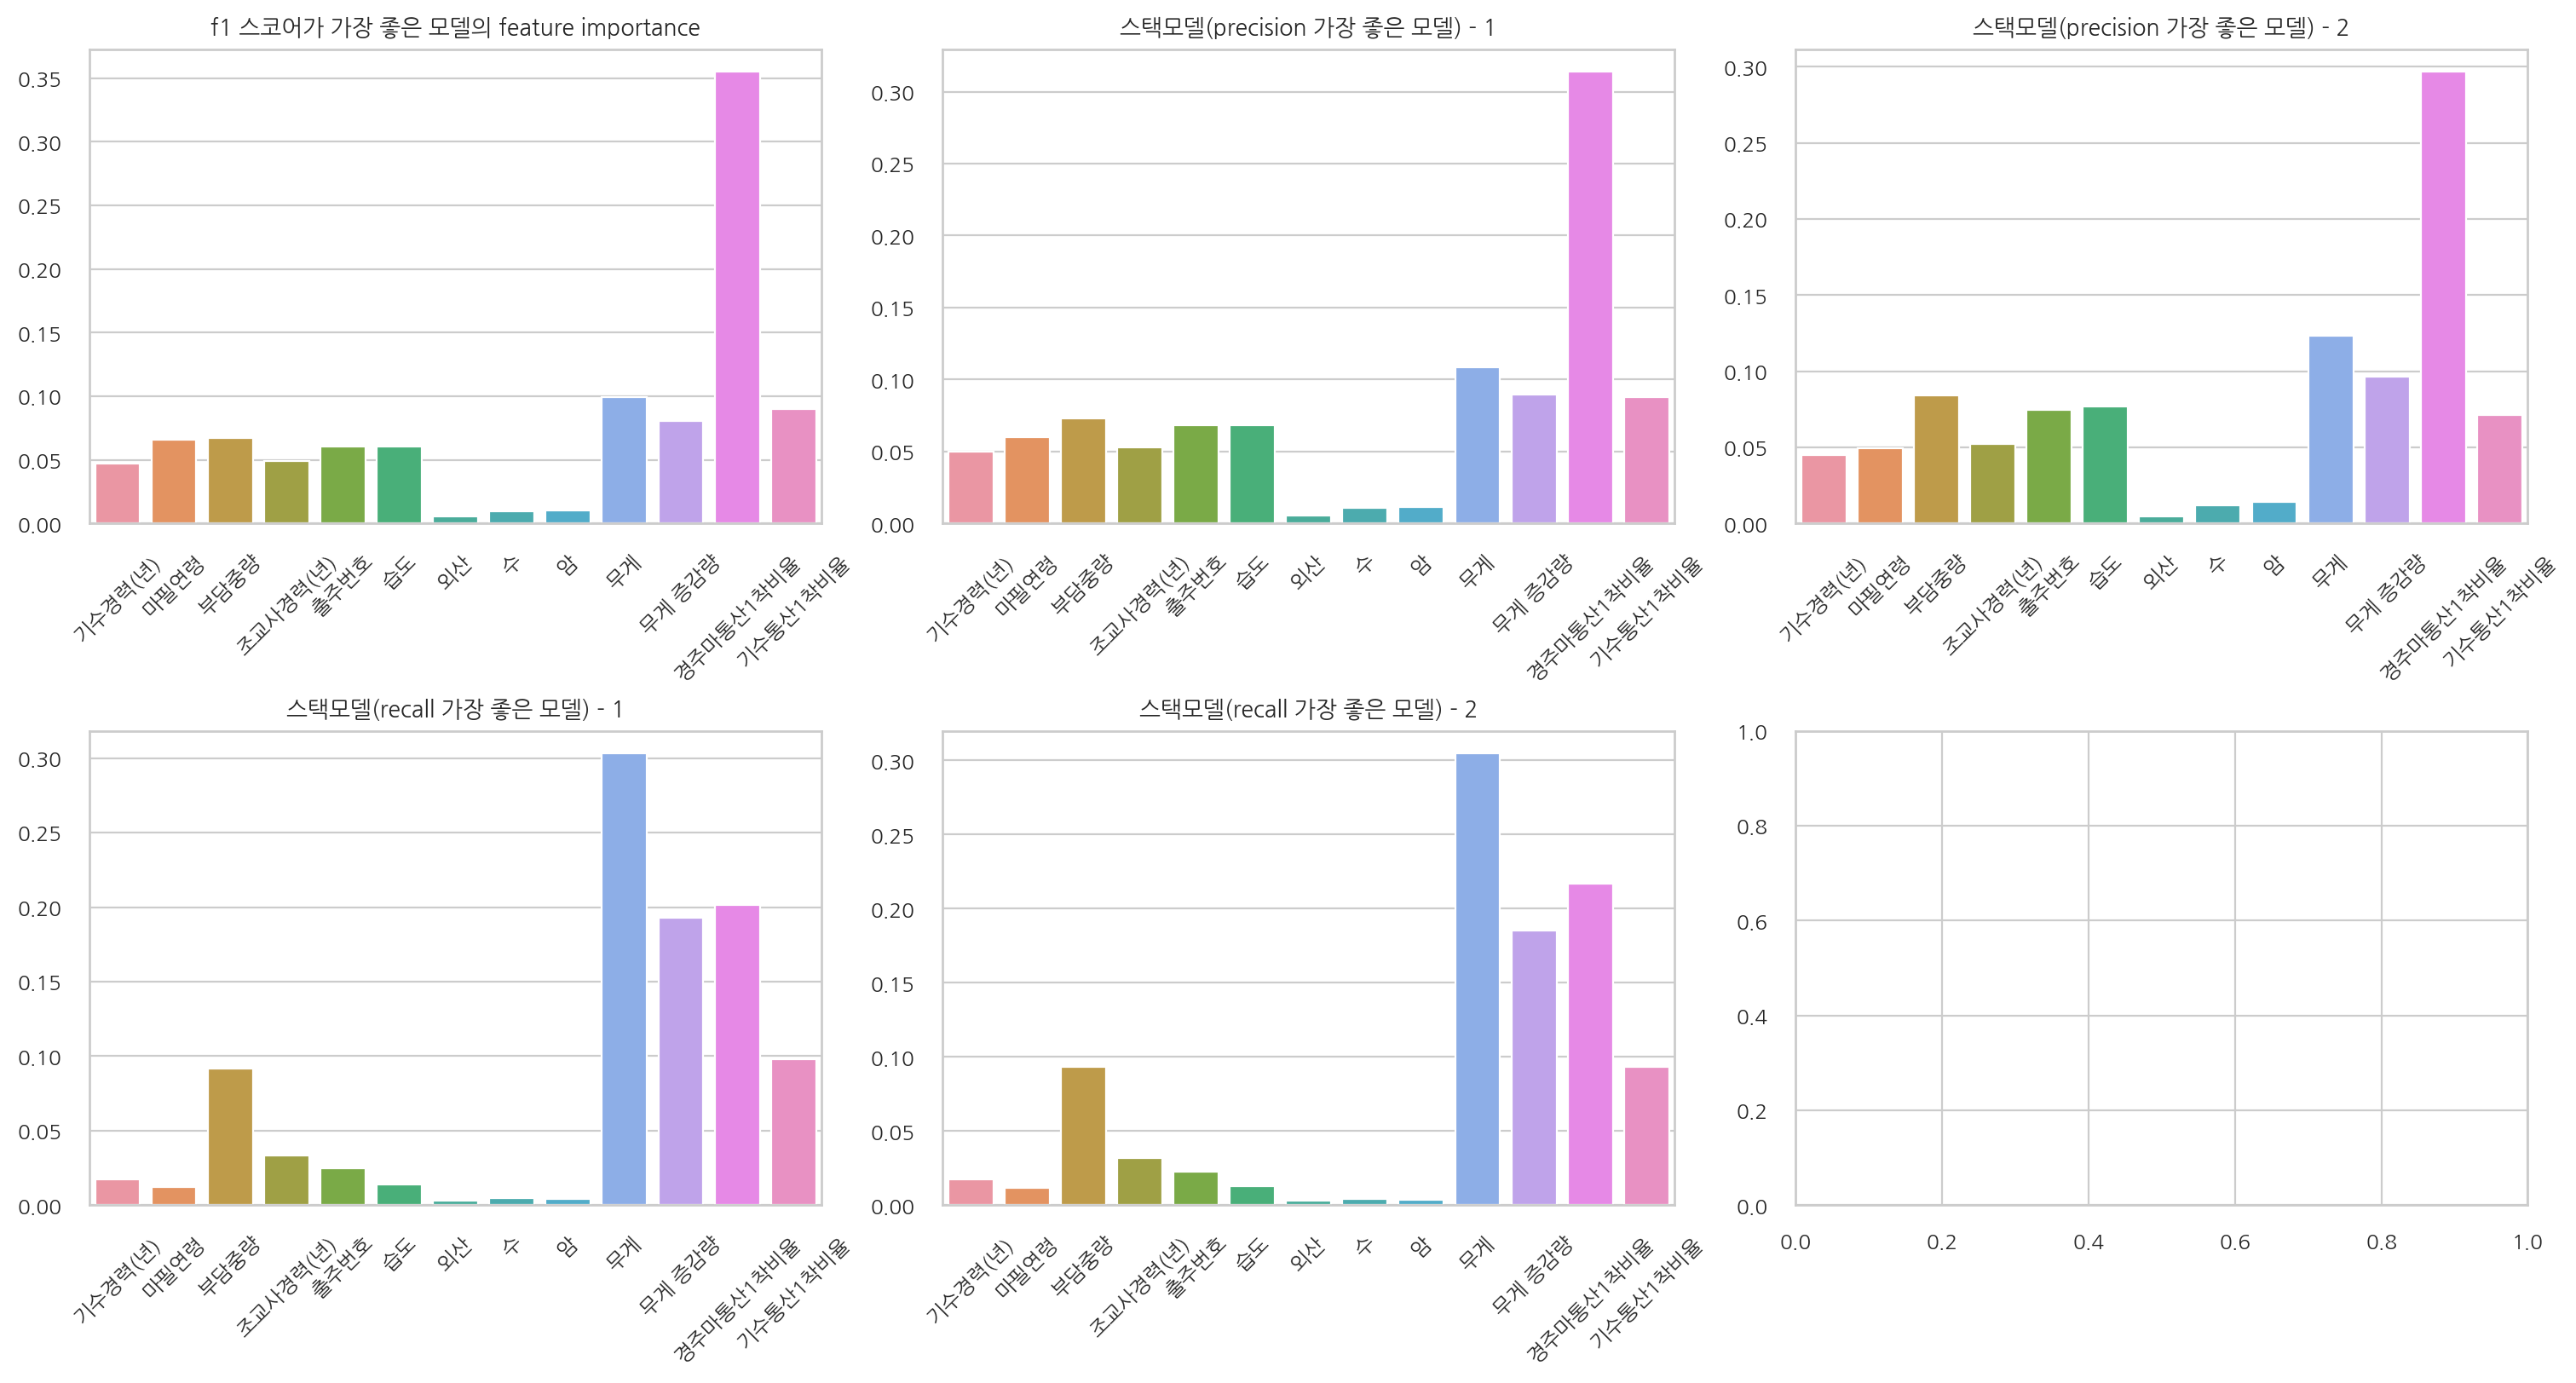

In [46]:
# 각 모델별 피쳐 중요도
def see_feature_importance(model, name, axe):
    featurename = horse_run.columns[1:]
    sns.barplot(x=featurename,y=model.feature_importances_, ax=axe)
    axe.set_xticklabels(featurename, rotation = 45)
    axe.set_title(name);

fig, ax = plt.subplots(2,3,figsize=(15, 8))
ax = ax.flatten()
see_feature_importance(best_worst_default["best_of_ros_rf_rs_recall"],
                       "f1 스코어가 가장 좋은 모델의 feature importance",
                       ax[0])
see_feature_importance(best_worst_default["stacked_best_of_ros_rf_rs_precision,best_of_ros_dt_rs_recall"].estimators[0][1],
                       "스택모델(precision 가장 좋은 모델) - 1",
                       ax[1])
see_feature_importance(best_worst_default["stacked_best_of_ros_rf_rs_precision,best_of_ros_dt_rs_recall"].estimators[1][1],
                       "스택모델(precision 가장 좋은 모델) - 2",
                       ax[2])
see_feature_importance(best_worst_default["stacked_best_of_ros_ad_rs_precision,best_of_ros_ad_rs_recall"].estimators[0][1],
                       "스택모델(recall 가장 좋은 모델) - 1",
                       ax[3])
see_feature_importance(best_worst_default["stacked_best_of_ros_ad_rs_precision,best_of_ros_ad_rs_recall"].estimators[1][1],
                       "스택모델(recall 가장 좋은 모델) - 2",
                       ax[4])

### 피쳐 중요도에 따른 결과

In [47]:
paramett = best_worst_default["best_of_ros_rf_rs_recall"].get_params()

In [48]:
# 가장 중요하다고 지시하는 4개의 피쳐만 골라 최상의 파라미터로 ada boost 를 돌려 실험

importances_ada_boost = AdaBoostClassifier(n_estimators=1970)
importances_ada_boost.fit(x_ros.iloc[:,-4:],y_ros)

AdaBoostClassifier(n_estimators=1970)

In [49]:
result(importances_ada_boost, x_ros.iloc[:,-4:], y_ros, test_x.iloc[:,-4:], test_y)

정확도 0.6951495553759095
confusion_matri
 [[7741 3482]
 [ 289  858]]

classification_report
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     11223
           1       0.20      0.75      0.31      1147

    accuracy                           0.70     12370
   macro avg       0.58      0.72      0.56     12370
weighted avg       0.89      0.70      0.76     12370

**************************************************


### DNN 으로 모델 돌려보기

In [50]:
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 표준 편차로 정규화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(x_ros)

#텐서로 변환
x_ros_tensor = tf.convert_to_tensor(df_scaled, dtype=tf.float32)
y_ros_tensor = tf.convert_to_tensor(y_ros, dtype=tf.float32)

random.seed(42)

#입력노드 수 = feature 수
input_node = 13
#출력노드 수
output_node = 1

#모델
dnn = Sequential(name = "horse_classifier")
dnn.add(Dense(256,
              kernel_initializer='he_normal',
              activation = "relu",
              input_shape=(input_node,)
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(128,
              kernel_initializer='he_normal',
              activation = "relu",
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(64,
              kernel_initializer='he_normal',
              activation = "relu",
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(32,
              kernel_initializer='he_normal',
              activation = "relu",
             ))
dnn.add(Dropout(0.3))
dnn.add(Dense(1,
              kernel_initializer='he_normal',
              activation = "sigmoid",
             ))

adam = Adam(learning_rate=0.001)

dnn.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics = ['accuracy'])

#validation loss가 연속 3번 감소하지 않으면 조기종료
early_stopping = EarlyStopping(patience = 3,
                               restore_best_weights=True)

dnn_hist = dnn.fit(x_ros_tensor,
                   y_ros_tensor,
                   epochs=2,
                   batch_size=302,
                   validation_split=0.2,
                   callbacks=[early_stopping],
                   verbose = 1
                  )

Epoch 1/2
238/238 [==============================] - 4s 5ms/step - loss: 0.6102 - accuracy: 0.6813 - val_loss: 0.7030 - val_accuracy: 0.5278
Epoch 2/2
238/238 [==============================] - 1s 5ms/step - loss: 0.5372 - accuracy: 0.7288 - val_loss: 0.6559 - val_accuracy: 0.6274


In [51]:
dnn.evaluate(tf.convert_to_tensor(test_x, dtype=tf.float32), tf.convert_to_tensor(test_y, dtype=tf.float32))

387/387 [==============================] - 1s 2ms/step - loss: 1.6815 - accuracy: 0.1631


[1.681537389755249, 0.16313661634922028]

In [52]:
pred_dnn = dnn.predict(tf.convert_to_tensor(test_x, dtype=tf.float32))
pred_dnn = (pred_dnn > 0.5).astype(int)
pred_dnn

387/387 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [53]:
pred_dnn.sum()

11429

In [54]:
test_y.sum() / len(test_y)

0.09272433306386418

In [55]:
print("정확도",metrics.accuracy_score(pred_dnn, test_y))
print("confusion_matrix",confusion_matrix(test_y, pred_dnn))
print("classification_report")
print(classification_report(test_y, pred_dnn))

정확도 0.16313662085691188
confusion_matrix [[  906 10317]
 [   35  1112]]
classification_report
              precision    recall  f1-score   support

           0       0.96      0.08      0.15     11223
           1       0.10      0.97      0.18      1147

    accuracy                           0.16     12370
   macro avg       0.53      0.53      0.16     12370
weighted avg       0.88      0.16      0.15     12370

